In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2024-03-07 15:49 (eradiate v0.25.1.dev31+g2a83b0ba.d20240229)*

## The particle layer interface

We start by activating the IPython extension and importing and aliasing a few useful components. We also select the CKD mode.

In [2]:
%load_ext eradiate
import eradiate
import numpy as np
import matplotlib.pyplot as plt
from rich.pretty import pprint
from eradiate.notebook.tutorials import plot_sigma_t

eradiate.set_mode("ckd")

In [3]:
import eradiate.scenes as ertsc
from eradiate import unit_registry as ureg

In [4]:
particle_layer_default = ertsc.atmosphere.ParticleLayer()
particle_layer_default


ParticleLayer(
    id='atmosphere',
    geometry=PlaneParallelGeometry(
        toa_altitude=120.0 km,
        ground_altitude=0.0 km,
        zgrid=ZGrid(
            levels=[0.0 100.0 200.0 ... 119800.0 119900.0 120000.0] m,
            _layers=[50.0 150.0 250.0 ... 119750.0 119850.0 119950.0] m,
            _layer_height=100.0 m,
            _total_height=120000.0 m
        ),
        width=1000000.0 km
    ),
    scale=None,
    bottom=0.0 km,
    top=1.0 km,
    distribution=UniformParticleDistribution(bounds=array([0., 1.])),
    w_ref=550 nm,
    tau_ref=0.2,
    dataset=<xarray.Dataset | source='/home/leroyv/Documents/src/rayference/rtm/eradiate/resources/data/spectra/particles/govaerts_2021-continental.nc'>,
    has_absorption=True,
    has_scattering=True,
    _phase=TabulatedPhaseFunction(
        id='phase_atmosphere',
        data=<xarray.DataArray | name='phase', dims=['w', 'mu', 'i', 'j'], source='/home/leroyv/Documents/src/rayference/rtm/eradiate/resources/data/spectra

We see that our `particle_layer_default` variable represents an aerosol layer with:

* a vertical extent from 0 to 1 km;
* a uniform particle density distribution within that extent;
* an optical thickness at 550 nm equal to 0.2.

We also note that the `geometry` field is set to a default suitable for the simulation of a typical atmospheric profile, ranging from 0 to 120 km with a 100 m grid step.

We can now visualize the extinction coefficient using the following convenience function:

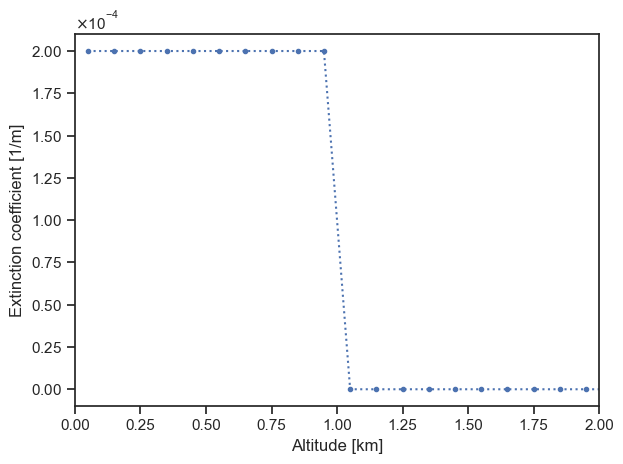

In [5]:
plot_sigma_t(particle_layer_default, altitude_extent=[0, 2])

We note that the extinction coefficient drops to 0 above 1 km: the particle layer cover the [0, 1] km region, and the rest of the atmospheric profile consists in a vacuum.

Now, let's define another particle layer with a different optical thickness:

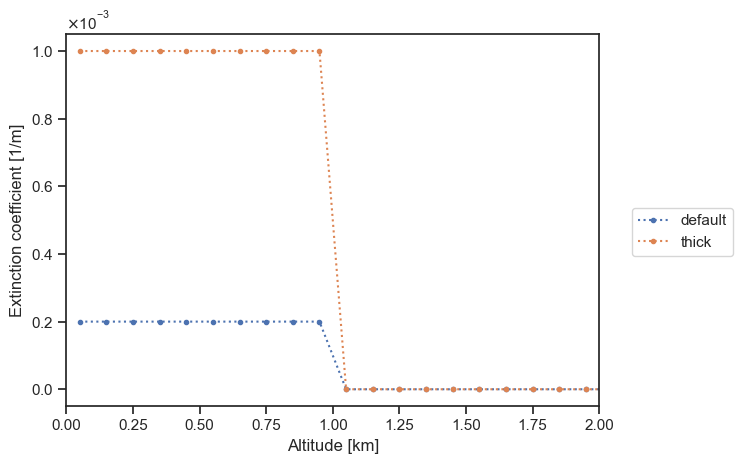

In [6]:
particle_layer_thick = ertsc.atmosphere.ParticleLayer(tau_ref=1.0)
plot_sigma_t(
    particle_layer_default,
    particle_layer_thick,
    labels=["default", "thick"],
    altitude_extent=[0, 2],
)

We can also modify the extent of our particle using the *bottom* and *top* parameters:

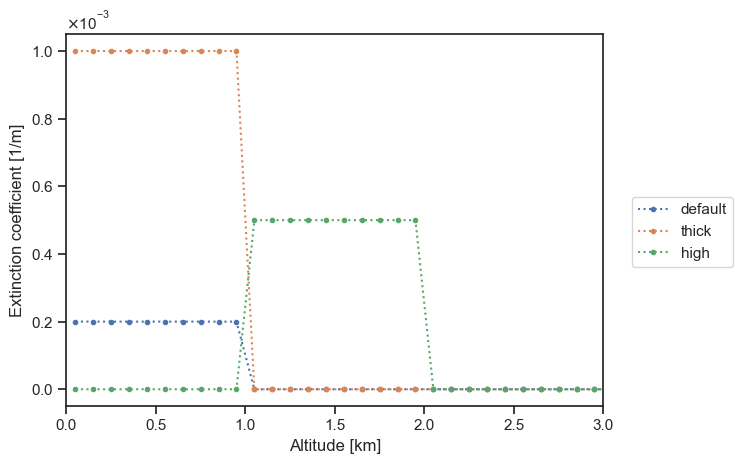

In [7]:
particle_layer_high = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.5, bottom=1 * ureg.km, top=2 * ureg.km
)
plot_sigma_t(
    particle_layer_default,
    particle_layer_thick,
    particle_layer_high,
    labels=["default", "thick", "high"],
    altitude_extent=[0, 3],
)

We can vary the particle density distribution within the defined bounds:

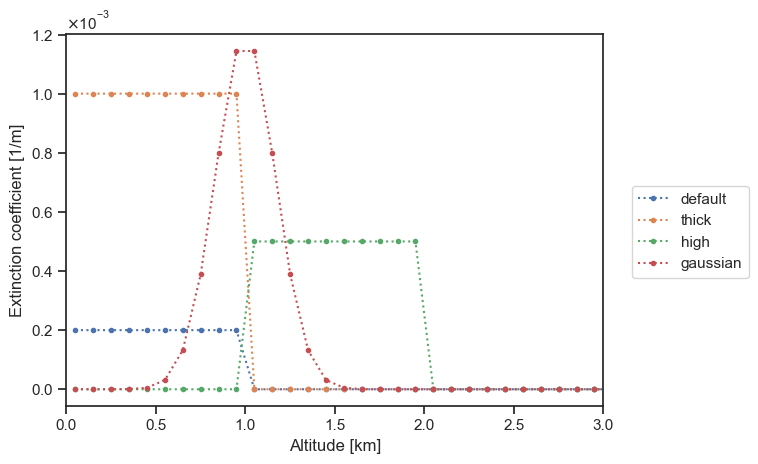

In [8]:
particle_layer_gaussian = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.5,
    bottom=0.5 * ureg.km,
    top=1.5 * ureg.km,
    distribution="gaussian",
)

plot_sigma_t(
    particle_layer_default,
    particle_layer_thick,
    particle_layer_high,
    particle_layer_gaussian,
    labels=["default", "thick", "high", "gaussian"],
    altitude_extent=[0, 3],
)

Finally, we can modify the altitude grid to allow for a more accurate extinction distribution profile:

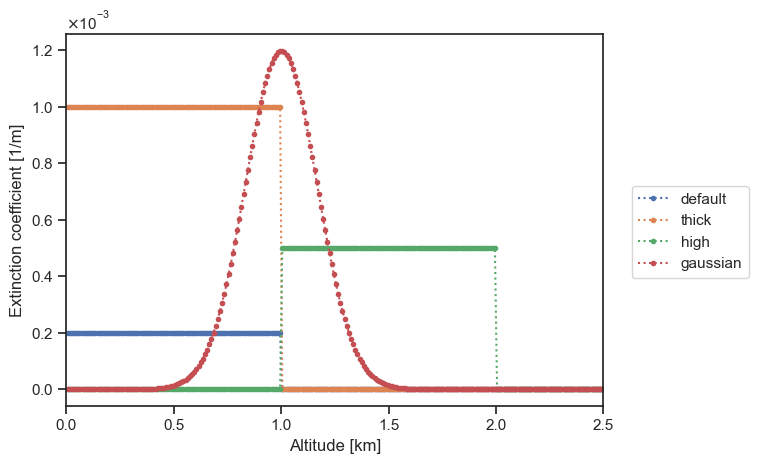

In [9]:
geometry = ertsc.geometry.PlaneParallelGeometry(
    zgrid=np.arange(0, 10001, 10) * ureg.m,
    toa_altitude=10 * ureg.km,
)

for particle_layer in [
    particle_layer_default,
    particle_layer_thick,
    particle_layer_high,
    particle_layer_gaussian,
]:
    particle_layer.geometry = geometry

plot_sigma_t(
    particle_layer_default,
    particle_layer_thick,
    particle_layer_high,
    particle_layer_gaussian,
    labels=["default", "thick", "high", "gaussian"],
    altitude_extent=[0, 2.5],
)

In [10]:
exponential = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.05,
    bottom=0 * ureg.km,
    top=6 * ureg.km,
    distribution="exponential",
)

gaussian = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.02,
    bottom=1 * ureg.km,
    top=2 * ureg.km,
    distribution="gaussian",
)

atmosphere = ertsc.atmosphere.HeterogeneousAtmosphere(
    molecular_atmosphere={"type": "molecular"},
    particle_layers=[exponential, gaussian]
)

We can display the extinction coefficient for the full atmospheric profile and all its components as follows (note that we restrict the view range to the [0, 10] km extent for clarity):

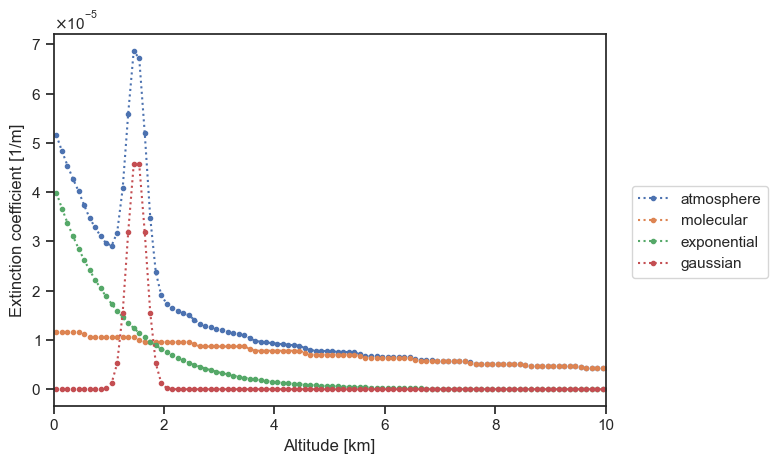

In [11]:
plot_sigma_t(
    atmosphere,
    atmosphere.molecular_atmosphere,
    exponential,
    gaussian,
    labels=["atmosphere", "molecular", "exponential", "gaussian"],
    altitude_extent=(0, 10),
)

## Running the simulation

We can now use this atmosphere definition to run a 1D simulation and compute the top-of-atmosphere BRF:

In [12]:
# Show only spectral loop progress
eradiate.config.progress = "spectral_loop"

exp = eradiate.experiments.AtmosphereExperiment(
    surface={"type": "lambertian", "reflectance": 1.0},
    atmosphere=atmosphere,
    illumination={"type": "directional", "zenith": 30.0, "azimuth": 0.0},
    measures={
        "type": "mdistant",
        "construct": "hplane",
        "zeniths": np.arange(-75, 76, 5),
        "azimuth": 0.0,
        "srf": {"type": "multi_delta", "wavelengths": 550.0 * ureg.nm},  # Run the simulation for the 550 nm bin
        "spp": 10000,
    },
)
result = eradiate.run(exp)
result

0/16|          | 00:00, ETA=?

<xarray.Dataset> Size: 2kB
Dimensions:     (sza: 1, saa: 1, w: 1, y_index: 1, x_index: 31)
Coordinates:
  * sza         (sza) float64 8B 30.0
  * saa         (saa) float64 8B 0.0
  * w           (w) float64 8B 551.0
  * y_index     (y_index) int64 8B 0
    y           (y_index) float64 8B 0.0
  * x_index     (x_index) int64 248B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
    x           (x_index) float64 248B 0.0 0.03333 0.06667 ... 0.9333 0.9667 1.0
    vza         (x_index, y_index) int64 248B -75 -70 -65 -60 ... 60 65 70 75
    vaa         (x_index, y_index) int64 248B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    bin_wmin    (w) float64 8B 549.5
    bin_wmax    (w) float64 8B 552.5
Data variables:
    radiance    (w, y_index, x_index, saa, sza) float64 248B 0.4164 ... 0.4209
    brdf        (w, y_index, x_index, saa, sza) float64 248B 0.2548 ... 0.2576
    brf         (w, y_index, x_index, saa, sza) float64 248B 0.8005 ... 0.8093
    irradiance  (sza, saa, w) float64 8B 1.634

And we can plot the computed TOA BRF:

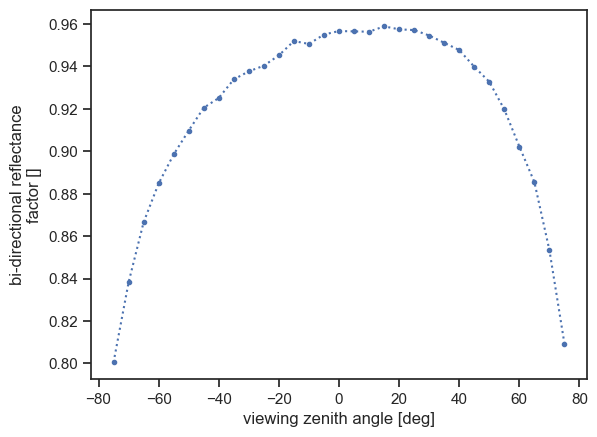

In [13]:
with plt.rc_context({"lines.marker": ".", "lines.linestyle": ":"}):
    result.brf.squeeze(drop=True).plot(x="vza");